In [0]:
import tensorflow as tf

In [0]:
from tensorflow.keras import layers, Model

In [5]:
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2

pre_model = MobileNetV2(include_top=False,
                       input_shape=(150,150,3),
                       weights='imagenet')

for layer in pre_model.layers:
  layer.trainable = False

/usr/local/lib/python3.6/dist-packages/keras_applications/mobilenet_v2.py:294: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  warnings.warn('`input_shape` is undefined or non-square, '
W0827 12:12:39.002914 140045736941440 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


9412608/9406464 [==============================] - 1s 0us/step


In [6]:
pre_model.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 151, 151, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 75, 75, 32)   864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 75, 75, 32)   128         Conv1[0][0]                      
_______________________________________________________________________________

In [8]:
last_layer = pre_model.get_layer('block_16_depthwise_relu')
print('Last Layer Output :- ', last_layer.output_shape)
last_output = last_layer.output
print(last_output)

Last Layer Output :-  (None, 5, 5, 960)
Tensor("block_16_depthwise_relu/Relu6:0", shape=(?, 5, 5, 960), dtype=float32)


In [12]:
from tensorflow.keras.optimizers import RMSprop

x = layers.Flatten()(last_output)

x = layers.Dense(1024, activation='relu')(x)

x = layers.Dropout(0.2)(x)

x = layers.Dense(1, activation='sigmoid')(x)

model = Model(pre_model.input, x)

model.compile(loss='binary_crossentropy',
             optimizer = RMSprop(lr=0.0001),
             metrics=['acc'])

W0827 12:27:17.276973 140045736941440 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/nn_impl.py:180: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [0]:
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('acc')>0.999):
      print("\nReached 99.9% accuracy so cancelling training!")
      self.model.stop_training = True

In [14]:
# Get the Horse or Human dataset
!wget --no-check-certificate https://storage.googleapis.com/laurencemoroney-blog.appspot.com/horse-or-human.zip -O /tmp/horse-or-human.zip

# Get the Horse or Human Validation dataset
!wget --no-check-certificate https://storage.googleapis.com/laurencemoroney-blog.appspot.com/validation-horse-or-human.zip -O /tmp/validation-horse-or-human.zip 
  
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import os
import zipfile

local_zip = '//tmp/horse-or-human.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp/training')
zip_ref.close()

local_zip = '//tmp/validation-horse-or-human.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp/validation')
zip_ref.close()

--2019-08-27 12:31:26--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/horse-or-human.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.133.128, 2a00:1450:400c:c07::80
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.133.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 149574867 (143M) [application/zip]
Saving to: ‘/tmp/horse-or-human.zip’

/tmp/horse-or-human 100%[===================>] 142.65M  85.7MB/s    in 1.7s    

2019-08-27 12:31:27 (85.7 MB/s) - ‘/tmp/horse-or-human.zip’ saved [149574867/149574867]

--2019-08-27 12:31:29--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/validation-horse-or-human.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 173.194.76.128, 2a00:1450:400c:c07::80
Connecting to storage.googleapis.com (storage.googleapis.com)|173.194.76.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 11480187 (11M) [application/

In [0]:
train_dir = '/tmp/training'
validation_dir = '/tmp/validation'

train_horses_dir = os.path.join(train_dir, 'horses') # Directory with our training horse pictures
train_humans_dir = os.path.join(train_dir, 'humans') # Directory with our training humans pictures
validation_horses_dir = os.path.join(validation_dir, 'horses') # Directory with our validation horse pictures
validation_humans_dir = os.path.join(validation_dir, 'humans')# Directory with our validation humanas pictures

train_horses_fnames = os.listdir(train_horses_dir)
train_humans_fnames = os.listdir(train_humans_dir)
validation_horses_fnames = os.listdir(validation_horses_dir)
validation_humans_fnames = os.listdir(validation_humans_dir)

In [0]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [20]:
train_datagen = ImageDataGenerator(rescale=1./255,
                                   rotation_range = 40,
                                   width_shift_range = 0.2,
                                   height_shift_range = 0.2,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True,
                                   vertical_flip = True)

valid_datagen = ImageDataGenerator(rescale=1./255.)

train_generator = train_datagen.flow_from_directory(train_dir,
                                                   batch_size=20,
                                                   target_size=(150,150),
                                                   class_mode='binary')

valid_generator = valid_datagen.flow_from_directory(validation_dir,
                                                   batch_size=20,
                                                   target_size=(150,150),
                                                   class_mode='binary')

Found 1027 images belonging to 2 classes.
Found 256 images belonging to 2 classes.


In [22]:
callbacks = myCallback()

history = model.fit_generator(train_generator,
                             validation_data = valid_generator,
                             steps_per_epoch = 100,
                             epochs=100,
                             validation_steps=50,
                             verbose=2,
                             callbacks = [callbacks])

Epoch 1/100
100/100 - 30s - loss: 1.3313 - acc: 0.7761 - val_loss: 0.2169 - val_acc: 0.9221
Epoch 2/100
100/100 - 26s - loss: 0.3772 - acc: 0.9089 - val_loss: 0.0155 - val_acc: 0.9879
Epoch 3/100
100/100 - 26s - loss: 0.3390 - acc: 0.9245 - val_loss: 0.0201 - val_acc: 1.0000
Epoch 4/100
100/100 - 25s - loss: 0.1985 - acc: 0.9377 - val_loss: 0.0635 - val_acc: 0.9848
Epoch 5/100
100/100 - 25s - loss: 0.2125 - acc: 0.9428 - val_loss: 0.1021 - val_acc: 0.9686
Epoch 6/100
100/100 - 25s - loss: 0.1368 - acc: 0.9582 - val_loss: 0.1853 - val_acc: 0.9575
Epoch 7/100
100/100 - 25s - loss: 0.1773 - acc: 0.9529 - val_loss: 0.2370 - val_acc: 0.9453
Epoch 8/100
100/100 - 25s - loss: 0.1961 - acc: 0.9505 - val_loss: 0.2930 - val_acc: 0.9322
Epoch 9/100
100/100 - 25s - loss: 0.2378 - acc: 0.9478 - val_loss: 0.0641 - val_acc: 0.9838
Epoch 10/100
100/100 - 26s - loss: 0.1379 - acc: 0.9618 - val_loss: 0.3154 - val_acc: 0.9241
Epoch 11/100
100/100 - 26s - loss: 0.1069 - acc: 0.9676 - val_loss: 0.0030 - va

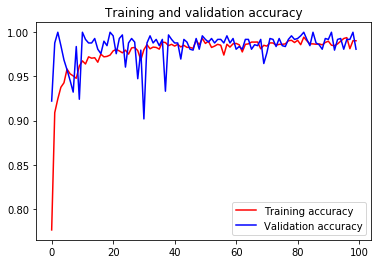

<Figure size 432x288 with 0 Axes>

In [23]:
import matplotlib.pyplot as plt
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()


plt.show()